In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.metrics import mean_squared_error
%pylab inline

from sklearn.ensemble import RandomForestRegressor
from category_encoders import OrdinalEncoder, TargetEncoder, OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit

from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

Populating the interactive namespace from numpy and matplotlib


In [2]:
## Importing Data
df = pd.read_csv('./data/SpotifyFeatures.csv')
## Target
y = df.popularity

# 1.0 - Superficial Exploratory Data Analysis

In [3]:
## Looking the full data
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [4]:
## Checking NULL
df.isnull().sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [5]:
print("Popularity max value:",df.popularity.max())
print("Popularity min value;",df.popularity.min())

Popularity max value: 100
Popularity min value; 0


In [6]:
df.groupby('genre').mean().popularity.sort_values()

genre
Children's Music     4.252637
A Capella            9.302521
Movie               12.174097
Opera               13.335628
Comedy              21.342630
Anime               24.258729
Ska                 28.612351
Classical           29.282195
Soundtrack          33.954800
Blues               34.742879
World               35.524077
Reggae              35.589328
Reggaeton           37.742915
Electronic          38.056095
Jazz                40.824383
Country             46.100416
Soul                47.027836
Folk                49.940209
Alternative         50.213430
R&B                 52.308719
Children’s Music    54.659040
Indie               54.701561
Dance               57.275256
Hip-Hop             58.423131
Rock                59.619392
Rap                 60.533795
Pop                 66.590667
Name: popularity, dtype: float64

# 2.0 - Splitting, Validation, Baseline

In [7]:
grp_splitter = GroupShuffleSplit(n_splits=1,random_state=0)

rows_train, rows_test = next(grp_splitter.split(df,y,groups=df['track_id']))

Xtrain, Xtest = df.iloc[rows_train].drop('popularity',axis=1), df.iloc[rows_test].drop('popularity',axis=1)
ytrain, ytest = df.popularity.iloc[rows_train], df.popularity.iloc[rows_test]

### 2.1 - Baselines

In [8]:
## Baseline Genre
genre_base = df.iloc[rows_train].groupby('genre')['popularity'].mean()
p_base = df.iloc[rows_test].genre.map(genre_base)
mean_squared_error(ytest,p_base)

94.45642029514539

In [9]:
## Baseline Artist
artist_base = df.iloc[rows_train].groupby('artist_name').popularity.mean()
p_base = df.iloc[rows_test].genre.map(artist_base).fillna(ytrain.mean())
mean_squared_error(ytest,p_base)


334.28313875548116

# 3.0 - Embeddings

In [10]:
## Encoders

ordinal_encoder = OrdinalEncoder(cols=['genre','artist_name'], handle_unknown='return_nan')
Xtrain2 = ordinal_encoder.fit_transform(Xtrain,ytrain)
Xtest2 = ordinal_encoder.transform(Xtest)

Xtest2['genre'] = Xtest2['genre'].fillna(28)
Xtest2['artist_name'] = Xtest2['artist_name'].fillna(13587)

In [11]:
## Genre Embedding
genre_input = layers.Input((1,))
genre_embedding = layers.Embedding(29,5)(genre_input)
genre_embedding = layers.Flatten()(genre_embedding)

## Artist Embedding

artist_name_input = layers.Input((1,))
artist_embedding = layers.Embedding(13588,5)(artist_name_input)
artist_embedding = layers.Flatten()(artist_embedding)

concat = layers.concatenate([genre_embedding, artist_embedding])
hidden1 = layers.Dense(10, activation='relu')(concat)
drop1 = layers.Dropout(0.5)(hidden1)
out = layers.Dense(1)(hidden1)

In [12]:
mdl = keras.Model([genre_input, artist_name_input], out)
mdl.compile(loss='mse',optimizer='adam')

In [13]:
mdl.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 5)         145         input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 5)         67940       input_2[0][0]                    
______________________________________________________________________________________________

In [14]:
train_X = [Xtrain2[['genre']].values, Xtrain2[['artist_name']].values]
test_X = [Xtest2[['genre']].values, Xtest2[['artist_name']].values]

In [15]:
mdl.fit(train_X,ytrain.values, validation_data=[test_X,ytest.values],batch_size=64, epochs=5)

Train on 186358 samples, validate on 46367 samples
Epoch 1/5
186358/186358 [==============================] - 9s 48us/sample - loss: 372.4805 - val_loss: 74.1963
Epoch 2/5
186358/186358 [==============================] - 7s 37us/sample - loss: 66.9783 - val_loss: 71.3758
Epoch 3/5
186358/186358 [==============================] - 7s 37us/sample - loss: 64.4743 - val_loss: 70.7647
Epoch 4/5
186358/186358 [==============================] - 7s 37us/sample - loss: 63.5645 - val_loss: 70.8400
Epoch 5/5
186358/186358 [==============================] - 7s 38us/sample - loss: 63.0771 - val_loss: 70.9844


# 4.0 - Neural Netwowrk + Numeric Features

In [14]:
Xtrain2_num = Xtrain.select_dtypes(include=np.number)
Xtest2_num = Xtest.select_dtypes(include=np.number)

scaler = StandardScaler()
Xtrain2_num = scaler.fit_transform(Xtrain2_num)
Xtest2_num = scaler.transform(Xtest2_num)

In [15]:
## Genre Embedding
genre_input = layers.Input((1,))
genre_embedding = layers.Embedding(29,5)(genre_input)
genre_embedding = layers.Flatten()(genre_embedding)

## Artist Embedding
artist_name_input = layers.Input((1,))
artist_embedding = layers.Embedding(13588,5)(artist_name_input)
artist_embedding = layers.Flatten()(artist_embedding)

## Numeric Features
nums = layers.Input((Xtrain2_num.shape[1],))

concat = layers.concatenate([genre_embedding, artist_embedding, nums])
hidden1 = layers.Dense(10, activation='relu')(concat)
drop1 = layers.Dropout(0.5)(hidden1)
out = layers.Dense(1)(hidden1)

In [16]:
mdl = keras.Model([genre_input, artist_name_input, nums], out)
mdl.compile(loss='mse', optimizer='adam')

In [17]:
mdl.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 5)         145         input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 5)         67940       input_4[0][0]                    
____________________________________________________________________________________________

In [18]:
train_X = [Xtrain2[['genre']].values, Xtrain2[['artist_name']].values, Xtrain2_num]
test_X = [Xtest2[['genre']].values, Xtest2[['artist_name']].values, Xtest2_num]

In [19]:
mdl.fit(train_X, ytrain.values, validation_data=[test_X, ytest.values], batch_size=64, epochs=5)

Train on 186358 samples, validate on 46367 samples
Epoch 1/5
186358/186358 [==============================] - 9s 48us/sample - loss: 349.6067 - val_loss: 73.7834
Epoch 2/5
186358/186358 [==============================] - 8s 41us/sample - loss: 66.4092 - val_loss: 70.5927
Epoch 3/5
186358/186358 [==============================] - 7s 39us/sample - loss: 63.6415 - val_loss: 70.0721
Epoch 4/5
186358/186358 [==============================] - 7s 39us/sample - loss: 62.6053 - val_loss: 69.9217
Epoch 5/5
186358/186358 [==============================] - 7s 39us/sample - loss: 62.0435 - val_loss: 69.5942


# 4.1 - LGBM Test

In [20]:
target_encoder = TargetEncoder(cols=['genre','artist_name'], handle_unknown='value')
Xtrain3 = target_encoder.fit_transform(Xtrain,ytrain).select_dtypes(include=np.number)
Xtest3 = target_encoder.transform(Xtest).select_dtypes(include=np.number)

In [21]:
## LGBM without tunning
mdl = LGBMRegressor(random_state=0,verbose=0)
mdl.fit(Xtrain3, ytrain)
p = mdl.predict(Xtest3)

mean_squared_error(ytest,p)

70.1271623018662

# 5.0 - SHAP

In [22]:
import shap
shap.initjs()

In [23]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(Xtrain3)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


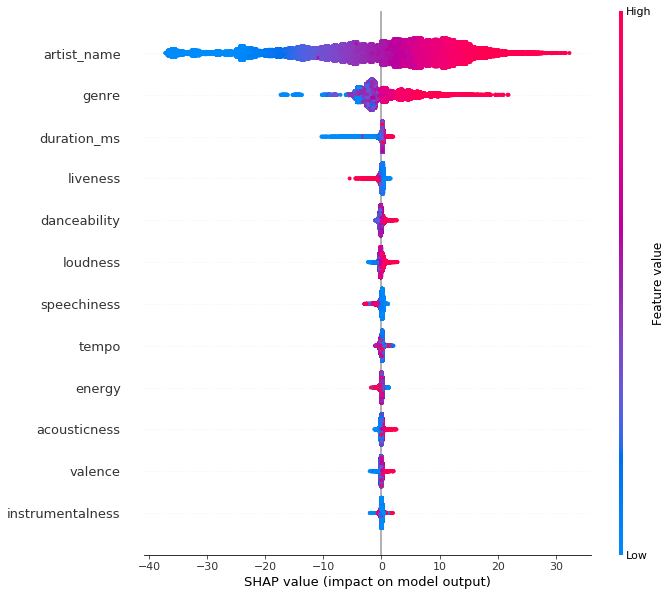

In [24]:
shap.summary_plot(shap_values,Xtrain3,plot_size=(10,10))

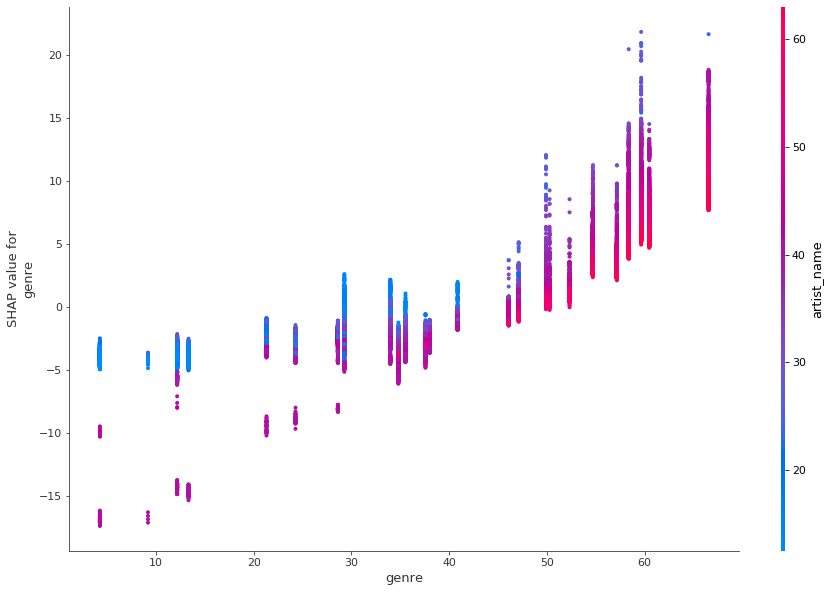

In [26]:
fig, ax = pylab.subplots(1,1, figsize=(15,10))
shap.dependence_plot('genre',shap_values,Xtrain3,ax=ax)

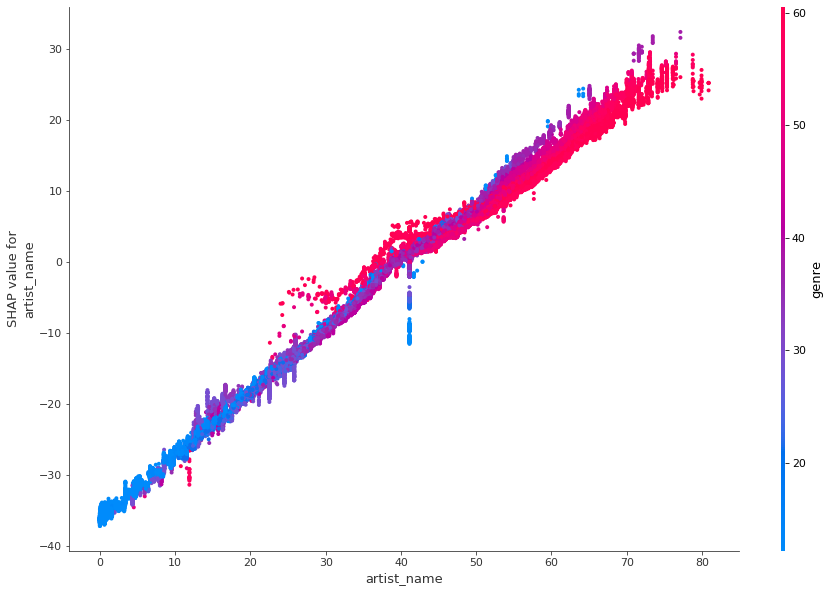

In [28]:
fig, ax = pylab.subplots(1,1, figsize=(15,10))
shap.dependence_plot('artist_name',shap_values,Xtrain3,ax=ax)